# Mercedes-Benz Greener Manufacturing

Welcome to a new competition! This time from Mercedes-Benz - our job is to predict how long a car on a production line will take to pass the testing phase. This is a classical regression problem, and we're evaluated with the R2 metric. Let's take a look at the data we're given:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()



So, a much smaller dataset than what we've been used to recently. No images here! :)
We're given a single train and test csv, indicating that the data should also be pretty simple to play with.

Time to load it into memory!
## Training set

In [2]:
df_train = pd.read_csv('train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


Just from this, we can see that our training data is made up of just 4000 rows, but has 400 seemingly anonymised features inside. As well as this, we are given an ID (which is not equal to the row number, this could be significant) and the target value, which is the number of seconds taken.

Let's start off by looking at the distribution of the target value:

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


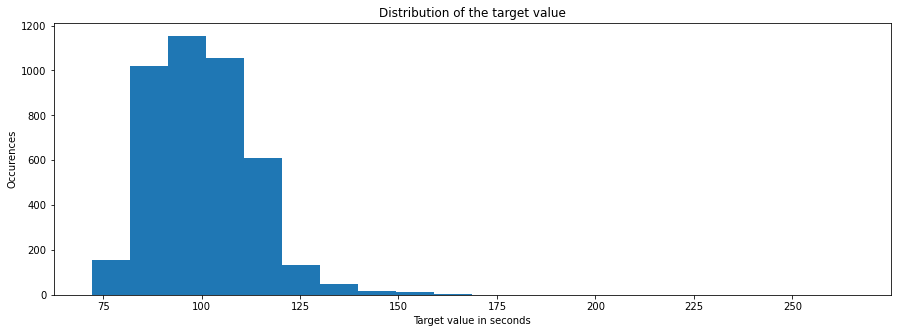

In [3]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

So we have a pretty standard distribution here, which is centred around almost exactly 100. Nothing special to note here, except there is a single outlier at 265 seconds where every other value is below 180.

The fact that our ID is not equal to the row ID seems to suggest that the train and test sets were randomly sampled from the same dataset, which could have some special order to it, for example a time series. Let's take a look at how this target value changes over time in order to understand whether we're given time series data.


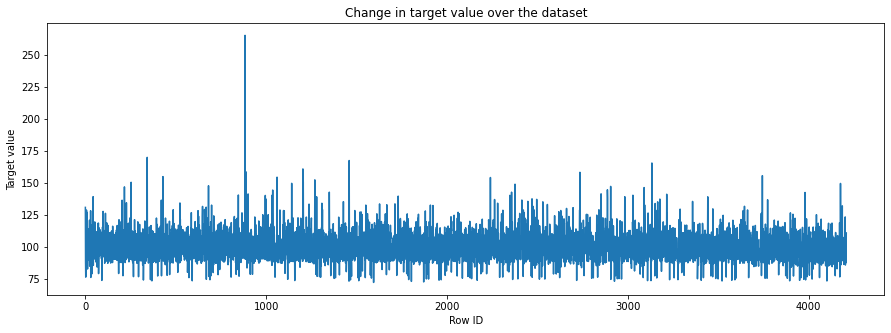

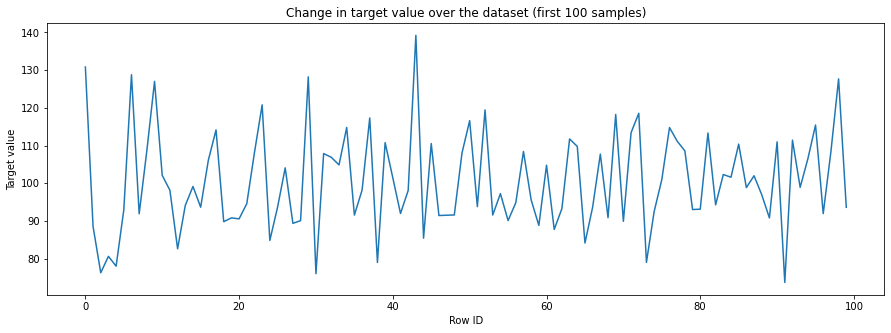

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(y_train)
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_train[:100])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset (first 100 samples)')
print()

At first glance, there doesn't seem to be anything overly suspicious here - looks like how a random sort would. I might take a closer look later but for now let's move on to the features.

## Feature analysis

In [5]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

So out of all our features, we are given 8 object (likely a string) variables, 368 integer variables. What about the cardinality of our features?

In [6]:
counts = [[], [], []]
for c in cols:
    typ = df_train[c].dtype
    uniq = len(np.unique(df_train[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Constant features: {} Binary features: {} Categorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 12 Binary features: 356 Categorical features: 8

Constant features: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Categorical features: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


<AxesSubplot:>

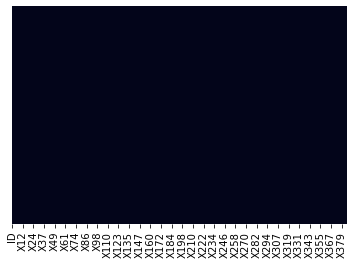

In [8]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False)

In [9]:
df_train.isnull().sum()

ID      0
y       0
X0      0
X1      0
X2      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 378, dtype: int64

In [12]:
pd.options.display.min_rows = 80

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


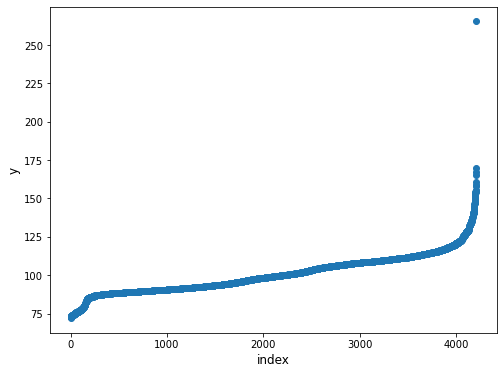

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(range(df_train.shape[0]), np.sort(df_train.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

In [18]:
df_train.drop(df_train[(df_train['y'] >200)].index, inplace=True)

In [20]:
df_train.drop(['X11','X93','X107','X223','X235','X268','X289','X290','X293','X297','X330','X347'],axis=1,inplace=True)

In [21]:
df_train.drop(['X257', 'X258', 'X295', 'X296', 'X369'],axis=1,inplace=True)

In [22]:
df_train.shape

(4208, 361)

In [23]:
df_train.drop(['ID'],axis=1,inplace=True)

In [24]:
##HAndle Categorical Features
columns= ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']

In [25]:
def category_onehot_multcols(multcolumns):
    df_final=final_df
    i=0
    for fields in multcolumns:
        
        print(fields)
        df1=pd.get_dummies(final_df[fields],drop_first=True)
        
        final_df.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:
            
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1
       
        
    df_final=pd.concat([final_df,df_final],axis=1)
        
    return df_final

In [26]:
main_df=df_train.copy()

In [27]:
## Combine Test Data 

test_df=pd.read_csv('formulatedtest.csv')

In [28]:
final_df=pd.concat([df_train,test_df],axis=0)

In [29]:
final_df.shape

(8417, 360)

In [30]:
final_df=category_onehot_multcols(columns)

X0
X1
X2
X3
X4
X5
X6
X8


In [31]:
final_df.shape

(8417, 555)

In [32]:
final_df =final_df.loc[:,~final_df.columns.duplicated()]

In [33]:
final_df.shape

(8417, 405)

In [34]:
df_Train=final_df.iloc[:4208,:]
df_Test=final_df.iloc[4208:,:]

In [35]:
y_train=df_Train['y']

In [36]:
y_train

0       130.81
1        88.53
2        76.26
3        80.62
4        78.02
5        92.93
6       128.76
7        91.91
8       108.67
9       126.99
10      102.09
11       98.12
12       82.62
13       94.12
14       99.15
15       93.64
16      106.10
17      114.13
18       89.81
19       90.81
20       90.56
21       94.57
22      108.14
23      120.77
24       84.84
25       93.59
26      104.07
27       89.37
28       90.08
29      128.19
         ...  
4179     85.93
4180     90.45
4181     90.06
4182     90.38
4183     95.56
4184    109.00
4185    109.64
4186    131.98
4187     98.15
4188    102.33
4189    102.42
4190     89.11
4191     88.93
4192    103.03
4193    107.24
4194     91.13
4195     86.23
4196     99.93
4197     89.25
4198     97.09
4199     88.24
4200    108.59
4201    107.39
4202    123.34
4203     85.71
4204    107.39
4205    108.77
4206    109.22
4207     87.48
4208    110.85
Name: y, Length: 4208, dtype: float64

In [37]:
df_Test.drop(['y'],axis=1,inplace=True)
X_train=df_Train.drop(['y'],axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [38]:
import xgboost
regressor=xgboost.XGBRegressor()

In [39]:
## Hyper Parameter Optimization
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [40]:
# Set up the random search with 4-fold cross validation
from sklearn.model_selection import RandomizedSearchCV
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [41]:
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [42]:
random_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
regressor=xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
regressor.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
y_pred=regressor.predict(df_Test)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [46]:
##Create Sample Submission file and Submit using ANN
pred=pd.DataFrame(y_pred)
sub_df=pd.read_csv('sample_submission.csv')
datasets=pd.concat([sub_df['ID'],pred],axis=1)
datasets.columns=['Id','y']
datasets.to_csv('sample_submission.csv',index=False)